## Supervised Classification of Vegetation in Maule

1. Build
var training = image/Sample(region, scale)
2. Train 
var classifier = ee.Classifier.cart().train(training)
3. Apply
var map = image.classify(classifier)
4. Assess 
var confusionMatrix = classifier.confusionMatrix()
var accuracy = confusionMatrix.accuracy()

In [1]:
# Example problem


import ee
import geemap
ee.Authenticate()
ee.Initialize()

# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_sr_l8(image):
  """Scales and masks Landsat 8 surface reflectance images."""
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
  saturation_mask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def _get_factor_img(factor_names):
    factor_list = image.toDictionary().select(factor_names).values()
    return ee.Image.constant(factor_list)

  scale_img = _get_factor_img([
      'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offset_img = _get_factor_img([
      'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True).updateMask(
      qa_mask).updateMask(saturation_mask)


# Make a cloud-free Landsat 8 surface reflectance composite.
l8_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterDate('2021-03-01', '2021-07-01')
    .map(prep_sr_l8)
    .median())

# Use these bands for prediction.
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']

# Load training points. The numeric property 'class' stores known labels.
points = ee.FeatureCollection('GOOGLE/EE/DEMOS/demo_landcover_labels')

# This property stores the land cover labels as consecutive
# integers starting from zero.
label = 'landcover'

# Overlay the points on the imagery to get training.
training = l8_image.select(bands).sampleRegions(
    collection=points, properties=[label], scale=30
)

# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label, bands)

# Classify the image with the same bands used for training.
classified = l8_image.select(bands).classify(trained)

# Display the inputs and the results.
m = geemap.Map()
m.set_center(-122.0877, 37.7880, 11)
m.add_layer(
    l8_image,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'image',
)
m.add_layer(
    classified,
    {'min': 0, 'max': 2, 'palette': ['orange', 'green', 'blue']},
    'classification',
)
m

Map(center=[37.788, -122.0877], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

In [2]:
points

In [38]:
import geopandas as gpd

# Define the path (assuming all related files are in the same folder)
shapefile_path = "07_regi_n_del_maule_actualizaci_n_2016/07_regi_n_del_maule_actualizaci_n_2016.shp"

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Preview the first few rows
print(gdf.head())

# Check available columns
#print("Columns:", gdf.columns)

# Check the coordinate reference system (CRS)
print("CRS:", gdf.crs)

# Get the basic metadata
print("Number of features:", len(gdf))
print("Geometry type:", gdf.geom_type.unique())

        ID ID_USO ID_SUBUSO ID_ESTRUC ID_COBER ID_ALTU ID_TIFO ID_STIF  \
0  20564.0     04        02        02       01       J      11      06   
1  20565.0     03        01        04       00     NaN     NaN     NaN   
2  20566.0     04        02        02       01       J      11      06   
3  20568.0     03        04        00       01     NaN     NaN     NaN   
4  20569.0     02        01       NaN      NaN     NaN     NaN     NaN   

  ID_ESP1 ID_ESP2  ... COOR_NORTE NOM_SNASPE TIPO_SNASP            NOM_REG  \
0      LC      Rm  ...        0.0        NaN        NaN  RegiÃ³n del Maule   
1      hl     NaN  ...        0.0        NaN        NaN  RegiÃ³n del Maule   
2      LC      Cf  ...        0.0        NaN        NaN  RegiÃ³n del Maule   
3      Ce      MB  ...        0.0        NaN        NaN  RegiÃ³n del Maule   
4     NaN     NaN  ...        0.0        NaN        NaN  RegiÃ³n del Maule   

  NOM_PROV NOM_COM   TC TIPO_POLI SUPERF_HA  \
0  Linares  Parral   14        03     2

In [39]:
# Data cleaning - USO y SUBUSO columns
gdf['SUBUSO'].value_counts()



SUBUSO
PlantaciÃ³n                                                                                                            37536
Bosque Nativo                                                                                                          30783
Matorral                                                                                                               12454
Matorral Arborescente                                                                                                  10290
RotaciÃ³n Cultivo-Pradera                                                                                               4898
Terreno de Uso AgrÃ­cola                                                                                                4463
Praderas                                                                                                                4410
Matorral-Pradera                                                                                                      

In [40]:
# Print unique SUBUSO values before cleaning
print("Before Cleaning:", gdf['SUBUSO'].unique())

# Define a dictionary to fix common encoding issues
fix_mapping = {
    "PlantaciÃ³n": "Plantación",
    "MinerÃ­a Industrial": "Minería Industrial",
    "Terreno de Uso AgrÃ­cola": "Terreno de Uso Agrícola",
    "VegetaciÃ³n HerbÃ¡cea en Orillas de RÃ­os": "Vegetación Herbácea en Orillas de Ríos",
    "Cajas de RÃ­os": "Cajas de Ríos",
    "RÃ­os": "Ríos",
    "Nieves": "Nieves",
}

# Apply manual fixes
gdf['SUBUSO'] = gdf['SUBUSO'].replace(fix_mapping)

# Print unique SUBUSO values after fixing encoding
print("After Encoding Fix:", gdf['SUBUSO'].unique())

# Remove corrupted/invalid categories
invalid_values = [
    "b'54657272656e6f20736f62726520656c204cc383c2ad6d69746520416c7469747564696e616c206465206c61205665676574616369c383c2'"
]

gdf = gdf[~gdf['SUBUSO'].isin(invalid_values)]

# Define valid categories to keep
valid_categories = [
    "Plantación", "Bosque Nativo", "Matorral", "Matorral Arborescente",
    "Rotación Cultivo-Pradera", "Terreno de Uso Agrícola", "Praderas",
    "Matorral-Pradera", "Bosque Mixto", "Ríos", "Ciudades, Pueblos, Zonas Industriales",
    "Cajas de Ríos", "Afloramientos Rocosos", "Lagos, Lagunas, Embalses, Tranques",
    "Otros sin Vegetación", "Otros Terrenos Húmedos", "Nieves", "Minería Industrial",
    "Playas y Dunas", "Derrumbe sin Vegetación", "Vegas", "Vegetación Herbácea en Orillas de Ríos",
    "Corridas de Lavas y Escoriales", "Matorral con Suculentas"
]

# Ensure "Plantación" is included in the filter
if "Plantación" not in valid_categories:
    valid_categories.append("Plantación")

# Filter dataset to keep only valid categories
gdf = gdf[gdf['SUBUSO'].isin(valid_categories)]

# Print final unique SUBUSO values
print("Final Cleaned Categories:", gdf['SUBUSO'].unique())

# Save cleaned data if needed
#gdf.to_file("cleaned_shapefile.shp")

Before Cleaning: ['Bosque Nativo' 'Praderas' 'Matorral Arborescente'
 'Terreno de Uso AgrÃ\xadcola' 'Lagos, Lagunas, Embalses, Tranques'
 'PlantaciÃ³n' 'Matorral-Pradera' 'Matorral' 'RotaciÃ³n Cultivo-Pradera'
 'Ciudades, Pueblos, Zonas Industriales' 'Cajas de RÃ\xados'
 'Bosque Mixto' 'RÃ\xados' 'Otros Terrenos HÃºmedos'
 'MinerÃ\xada Industrial' 'VegetaciÃ³n HerbÃ¡cea en Orillas de RÃ\xados'
 'Playas y Dunas' 'Otros sin VegetaciÃ³n' 'Vegas'
 b'54657272656e6f20736f62726520656c204cc383c2ad6d69746520416c7469747564696e616c206465206c61205665676574616369c383c2'
 'Nieves' 'Afloramientos Rocosos' 'Derrumbe sin VegetaciÃ³n'
 'Corridas de Lavas y Escoriales' 'Matorral con Suculentas']
After Encoding Fix: ['Bosque Nativo' 'Praderas' 'Matorral Arborescente'
 'Terreno de Uso Agrícola' 'Lagos, Lagunas, Embalses, Tranques'
 'Plantación' 'Matorral-Pradera' 'Matorral' 'RotaciÃ³n Cultivo-Pradera'
 'Ciudades, Pueblos, Zonas Industriales' 'Cajas de Ríos' 'Bosque Mixto'
 'Ríos' 'Otros Terrenos HÃºmedos' 

In [58]:
# Define a function to fix encoding issues
def fix_encoding(text):
    if isinstance(text, bytes):  # Handle byte strings
        text = text.decode('utf-8', 'ignore')
    return text.encode('latin1', 'ignore').decode('utf-8', 'ignore') if isinstance(text, str) else text



# Fix encoding issues in the "USO" column
gdf['USO'] = gdf['USO'].apply(fix_encoding)

# Define a dictionary to manually fix known issues
uso_fix_mapping = {
    "Terrenos AgrÃ­colas": "Terrenos Agrícolas",
    "Ã­reas Desprovistas de VegetaciÃ": "Áreas Desprovistas de Vegetación",
    "Ãreas Urbanas e Industriales": "Áreas Urbanas e Industriales",
    "Nieves Eternas y Glaciares": "Nieves Eternas y Glaciares",
    "Humedales": "Humedales"
}

# Apply the manual fixes
gdf['USO'] = gdf['USO'].replace(uso_fix_mapping)

# Check the unique values in the "USO" column after cleaning
print(gdf['USO'].value_counts())

# If you need to filter out some values, you can define the valid categories
valid_uso_categories = [
    "Bosques", "Praderas y Matorrales", "Terrenos Agrícolas", 
    "Áreas Desprovistas de Vegetación", "Cuerpos de Agua", 
    "Áreas Urbanas e Industriales", "Nieves Eternas y Glaciares", "Humedales"
]

# Filter to keep only valid categories in "USO"
gdf = gdf[gdf['USO'].isin(valid_uso_categories)]

# Display cleaned data
print(gdf['USO'].value_counts())


USO
Bosques                           70669
Praderas y Matorrales             30115
Terrenos Agrícolas                 4463
Áreas Desprovistas de Vegetaci     2329
Cuerpos de Agua                    2247
Áreas Urbanas e Industriales       1554
Nieves Eternas y Glaciares          129
Humedales                            82
Name: count, dtype: int64
USO
Bosques                         70669
Praderas y Matorrales           30115
Terrenos Agrícolas               4463
Cuerpos de Agua                  2247
Áreas Urbanas e Industriales     1554
Nieves Eternas y Glaciares        129
Humedales                          82
Name: count, dtype: int64


In [56]:
gdf['USO'].value_counts()

USO
Bosques                             70669
Praderas y Matorrales               30115
Terrenos AgrÃ­colas                  4463
Ãreas Desprovistas de VegetaciÃ     2329
Cuerpos de Agua                      2247
Ãreas Urbanas e Industriales        1554
Nieves Eternas y Glaciares            129
Humedales                              82
Name: count, dtype: int64

In [48]:
# Area occupied by type

subuso_area = gdf.groupby('SUBUSO')['SUPERF_HA'].sum().reset_index()
subuso_area = subuso_area.sort_values(by='SUPERF_HA', ascending=False)

# Display the result
print(subuso_area)

                                    SUBUSO  SUPERF_HA
13                              Plantación  634893.44
2                            Bosque Nativo  581514.91
17                 Terreno de Uso Agrícola  372299.89
7                                 Matorral  221057.01
15                                Praderas  169435.96
0                    Afloramientos Rocosos  143913.41
8                    Matorral Arborescente  117746.77
10                        Matorral-Pradera   54951.18
12                                  Nieves   48363.01
1                             Bosque Mixto   28674.71
4    Ciudades, Pueblos, Zonas Industriales   26086.44
6       Lagos, Lagunas, Embalses, Tranques   18984.84
16                                    Ríos   17084.91
5           Corridas de Lavas y Escoriales   12303.14
3                            Cajas de Ríos    9818.68
14                          Playas y Dunas    6519.53
19  Vegetación Herbácea en Orillas de Ríos     521.79
11                      Mine

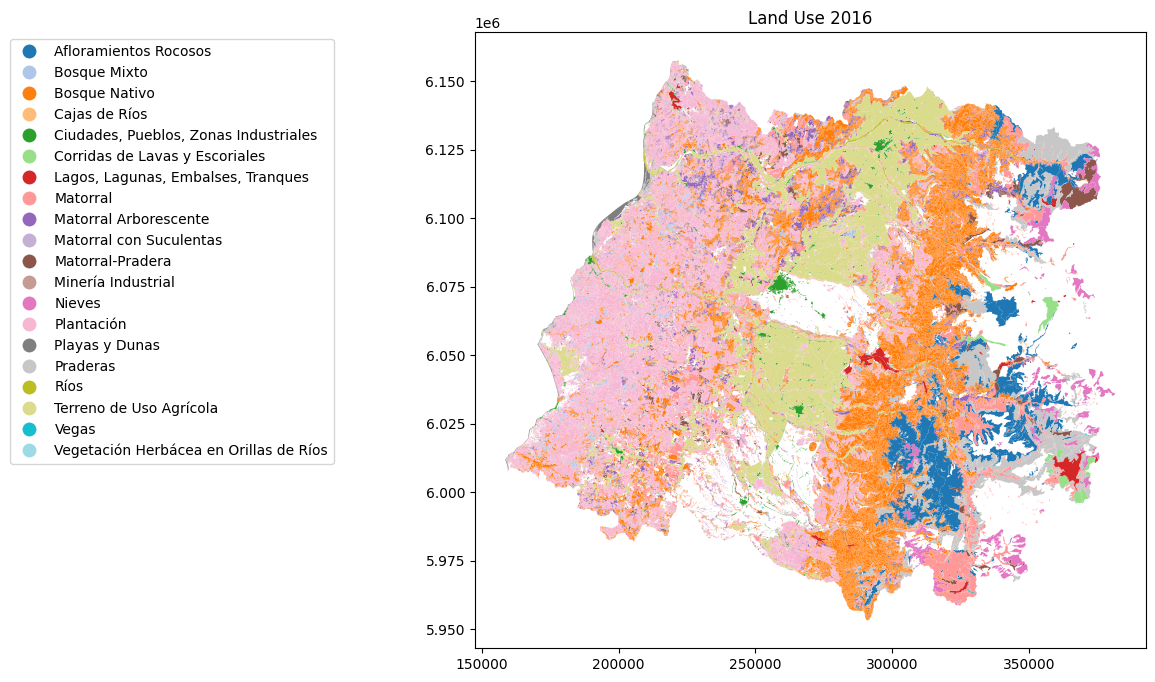

In [55]:
import matplotlib.pyplot as plt
# Filter the dataset
selected_subuso = [
    'Plantación', 'Bosque Nativo', 'Bosque Mixto', 'Terreno de Uso Agrícola', 
    'Matorral', 'Praderas', 'Afloramientos Rocosos', 'Matorral Arborescente', 
    'Matorral-Pradera', 'Nieves', 'Ciudades, Pueblos, Zonas Industriales', 
    'Lagos, Lagunas, Embalses, Tranques', 'Ríos'
]
gdf_filtered = gdf[gdf['SUBUSO'].isin(selected_subuso)]

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))
#gdf_filtered.plot(column='SUBUSO', cmap='tab20', legend=True, ax=ax)
gdf.plot(column='SUBUSO', cmap='tab20', legend=True, ax=ax)

# Adjust legend position to the left
leg = ax.get_legend()
leg.set_bbox_to_anchor((-0.2, 1))  # Moves the legend outside the plot to the left

# Add title
plt.title("Land Sub-Use Map 2016")

plt.show()

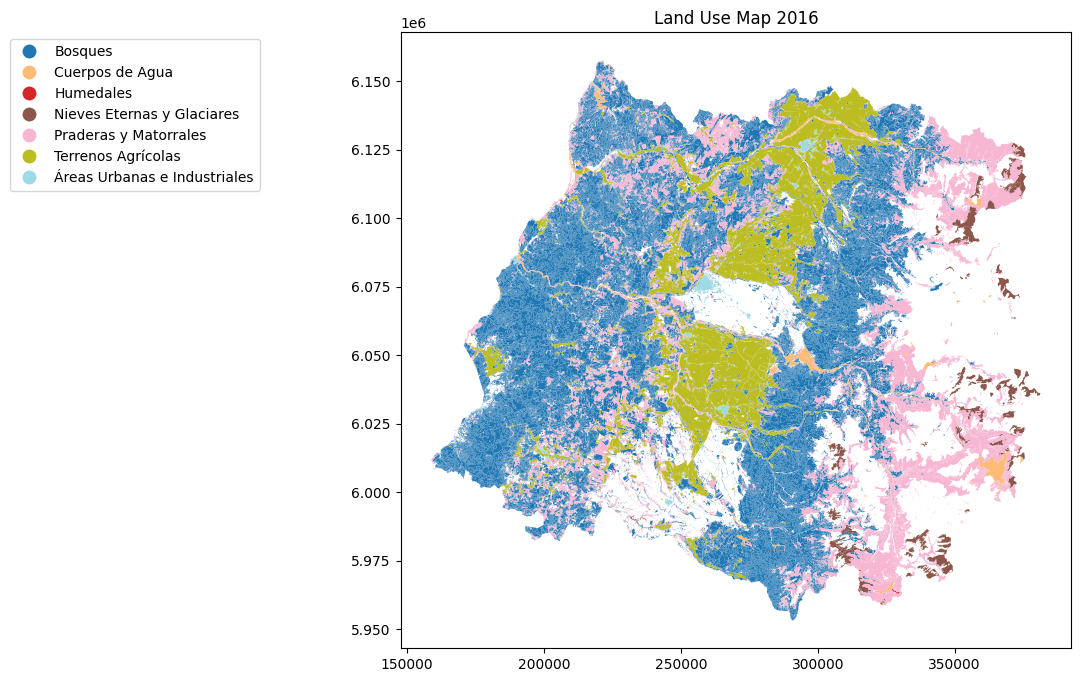

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))
#gdf_filtered.plot(column='SUBUSO', cmap='tab20', legend=True, ax=ax)
gdf.plot(column='USO', cmap='tab20', legend=True, ax=ax)

# Adjust legend position to the left
leg = ax.get_legend()
leg.set_bbox_to_anchor((-0.2, 1))  # Moves the legend outside the plot to the left

# Add title
plt.title("Land Use Map 2016")

plt.show()